while our implementation are decent enough, they are not optimized to work well on  large corpora:
    <br>
    1. the Gensim framework, consist of robust, efficient and scalable implementation of the Word2Vec model
    2. we will leverage this on Bible corpus

we will leverage this on Bible corpus, in our workflow:
    <br>
    1. we will tokenize our normalized corpus and then focus on the following 4 parameters in the Word2Vec model to build it
    2. the basic idea is to provide a corpus of documents as input and get feature vectors for the output

Internally:
    <br>
    1. it constructs a vocabulary based on the input text documents and learns vector representations for words based on various techniques,which we mentioned earlier
    2. one this complete, it builds a model that can be used to extract word vectors for each word in a document
    3. Using various techniques like average weighting or TF-IDF weighting,we can compute the averaged vector representation of a document using it's word vectors

we will be mainly focusing on the following paramters when we build our model from our sample training corpus:
    <br>
    1. size:
        1. this parameter is used to set the size or dimension for the word vectors and can range from tens to thousands.
        2. you can try various dimensions to see which gives the best result
    2. window:
        1. this paramter is used to set the context or window size that specifies the length of the window of words that should be considered for the algorithm to take into account as context when training
    3. min_count:
        1. this parameter specifies the minimum word count needed across the corpus for the word to be considered in the vocabulary
        2. this helps remove very specific words that may not have much significance since they occur very rarely in the documents
    4. sample:
        1. this parameter is used to downsample effects of occurance of frequent words
        2. values between 0.01 and 0.001 are usually idealm

After building our model, we will use our words of interest to see the top similar words for each of them

In [14]:
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from string import punctuation
from keras.preprocessing import text, sequence
from keras.utils import np_utils
from gensim.models import word2vec

In [7]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [12]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, epochs=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'worldly', 'sworn', 'promised', 'godly'],
 'jesus': ['peter', 'messias', 'apostles', 'repentance', 'john'],
 'noah': ['shem', 'japheth', 'ham', 'henoch', 'noe'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'flowing', 'rid'],
 'john': ['james', 'baptist', 'peter', 'herodias', 'galilee'],
 'gospel': ['christ', 'faith', 'afflictions', 'dispensation', 'preach'],
 'moses': ['congregation', 'children', 'elisheba', 'aaron', 'joshua'],
 'famine': ['pestilence', 'peril', 'deaths', 'overtaketh', 'blasting']}

Let's also visualize the words of interest and their similar words using their embedding vectors after reducing their dimensions to a 2D space with t-SNE

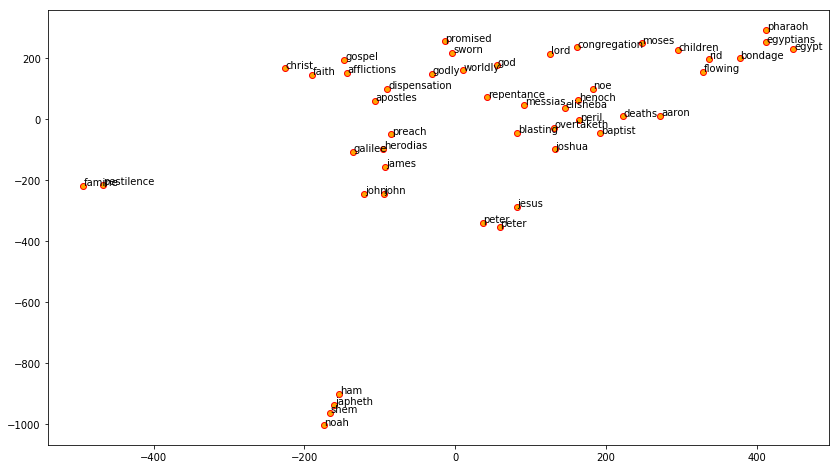

In [15]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')